# Tutorial 6 - Sieci neuronowe

## 1) Sieci MLP - multi-layer perceptron
### 1.1) Zasada działania

MLP (perceptron wielowarstwowy) jest algorytmem _uczenia nadzorowanego_. Dla danego zbioru wektorów cech X oraz wektora odpowiedzi y trenuje on _nieliniową_ fukcję $f: R^m \rightarrow R^o$, gdzie $m$ jest liczbą wymiarów wektorów wejściowych a $o$ liczbą wymiarów wektorów wyjściowych. Może być ona używana zarówno do rozwiązywania problemów klasyfikacji, jak i regresji.

Trenowana funkcja $f$ ma postać kilkuwarstwowej sieci. Każda warstwa złożona jest z pewnej ilości neuronów. Pierwsza warstwa jest _warstwą wejściową_, złożoną z $m$ neuronów. Kolejne warstwy złożone są z pewnej ilości neuronów, których wartości zależą od wartości w poprzedniej warstwie. Ostatnia warstwa - _warstwa wyjściowa_ - składa się z $o$ neuronów. Warstwy pomiędzy warstwą wejściową i wyjściową nazywamy _warstwami ukrytymi_. Wartość funkcji $f$ dla wektora $x \in R^m$ jest wartość neuronów wyjściowych dla wartości neuronów wejściowych równej $x$.

<img src="images/multilayerperceptron_network.png" style="width: 350px; text-align: left" />
Rysunek 1: sieć multi-layer perceptron (źródło: https://scikit-learn.org)

Wartość neuronu w warstwie wejściowej zależy od danych wejściowych. Wartość neuronu w warstwach ukrytych i warstwie wyjściowej zależy od sumy ważonej (kombinacji liniowej) wartości neuronów i dodatkowej wartości - bias'u. Dodatkowo, najlepiej aby wartość neuronu $\in [0, 1]$. W tym celu:
* dla _warstwy wejściowej_ - normalizujemy dane
* dla _warstw ukrytych_ i _warstwy wyjściowej_ - obliczoną sumę przepuszczamy przez __funkcję aktywacji__, której dziedziną jest $R$ a zbiorem wartości jest $[0, 1]$ . Przykładową funkcją aktywacji jest sigmoid: $f(x) = (1 + e^{-x})^{-1}$. Wykresy funkcji aktywacji znajdują się poniżej:

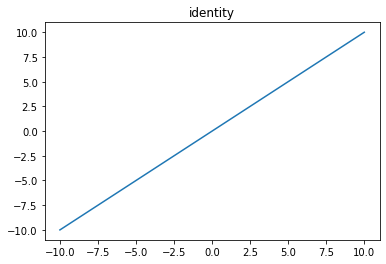

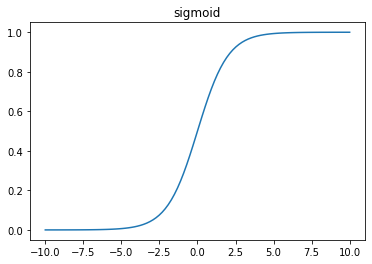

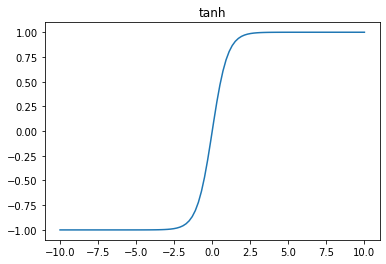

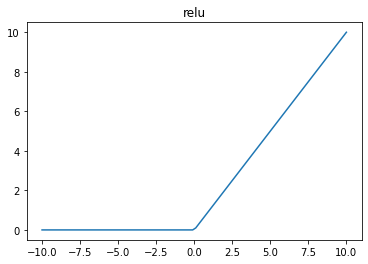

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

def plot(f, title):
    x = np.linspace(-10, 10, 100)
    y = [f(i) for i in x]
    plt.plot(x, y)
    plt.title(title)
    plt.show()
    
plot(lambda x: x, 'identity')
plot(lambda x: 1 / (1 + math.exp(-x)), 'sigmoid')
plot(lambda x: math.tanh(x), 'tanh')
plot(lambda x: max(0, x), 'relu')


Wykresy funkcji aktywacji

Możemy zauważyć, że obliczenie wartości neuronów dla warstwy składa się z dwóch kroków:
1. _przekształcenie affiniczne_ wektora wartości neuronów z poprzedniej warstwy. Przekształcenie affiniczne jest to przekształcenie w postaci $x \rightarrow f(x) + b$, gdzie f jest przekształceniem liniowym a b wektorem przesunięcia.
2. obliczenie wartości poszczególnych neuronów na podstawie wartości wektora uzyskanych w punkcie (1) z użyciem funkcji aktywacji

Przekształcenie affiniczne wektora $X$ w $X'$ możemy zamienić w przekształcenie liniowe, dodając do wektora X dodatkową współrzędną o wartości 1. Umożliwia to dodanie stałego współczynnika do kombinacji liniowych - mnożąc wagę razy 1 otrzymamy zawsze daną wagę (patrz rysunek 1). Dzięki temu, możemy przedstawić współczynniki w postaci macierzy przekształcenia liniowego, a samo przekształcenie zrealizować jako mnożenie macierzy przez wektor.

### 1.2) Trenowanie sieci
Parametrami funkcji f, które trenujemy, są:
* wagi średniej ważonej (`coefs_`) - dla każdego neuronu w warstwie $l$ wag jest tyle, ile neuronów w warstwie $l - 1$,
* bias'y (`intercepts_`) - po jednym dla każdego neuronu.

Jeśli ilość neuronów w warstwie l oznaczymy jako $n_l$, dla każdej warstwy mamy $(n_{l - 1} + 1) n_l$ wartości do wyznaczenia. Jeśli mamy L warstw w naszej sieci MLP, mamy $\sum_{l=2}^{L} ((n_{l - 1} + 1) n_l)$ wartości do wyznaczenia.

Trenowanie sieci neuronowej polega na minimalizacji funkcji strat (loss function) na danym zbiorze treningowym, wyrażającej "koszt" sieci neuronowej. Standardowo używa się sumy błędów średniokwadratowych pomiędzy wynikami sieci neuronowej a wartościami oczekiwanymi dla kolejnych wektorów wejściowych. Parametrami funkcji loss są wszystkie parametry (wagi średnich ważonych oraz bias'y) naszej sieci neuronowej. Ilość tych parametrów jest bardzo duża, dlatego nie stosuje się standardowej metody wyznaczania ekstremów funkcji wielu zmiennych (przyrównywanie pochodnych cząstkowych do zera). Zamiast tego, istnieją specjalne metody:
* `sgd` - schotastic gradient descent
* `adam` - another schotastic gradient descent
* `lbfgs` - another optimizer

Więcej informacji na temat tych metod znajduje się na wykładzie oraz prezentacji do tego tutoriala.

Na kanale 3blue3brown w serwisie YouTube znajduje się 4-odcinkowa seria ilustrująca działanie sieci neuronowej MLP z użyciem schotastic gradient descent na zbiorze MNIST - https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi.

### 1.3) Przykład
Na potrzeby tego tutoriala, wykorzystamy bibliotekę `scikit-learn`. Wykorzystuje ona jedynie CPU, przez co nie nadaje się do zastosowań o dużej skali. Obliczenia związane z sieciami neuronowymi dziś wykorzystuje się zazwyczaj z użyciem GPU lub specjalizowanych układów stworzonych do tego celu (np. opartych na FPGA lub będących częściami nowoczesnych układów SoC w smartfonach). Biblioteki takie jak `tensorflow`, `keras` bądź `pytorch` umożliwiają działania na sieciach neuronowych z wykorzystaniem GPU.

Działanie sieci MLP pokażemy standardowo na zbiorze `MNIST`:

In [2]:
import tensorflow as tf # korzystamy jedynie w celu pobrania zbioru MNIST

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Biblioteka `scikit-learn` udostępnia klasę `MLPClassifier`, implementującą algorytm MLP używający backpropagation do trenowania.

Konstruktor klasy `MLPClassifier` pozwala na ustawienie wielu parametrów, ich pełna lista dostępna jest w dokumentacji `scikit-learn`. Najważniejsze z nich to:
* __solver__ - metoda użyta do trenowania sieci. Dostępne metody: `"sgd"`\\`"adam"`\\`"lbfgs"`
* __hidden_layer_sizes__ -  lista rozmiarów warstw ukrytych
* __activation__ - użyta funkcja aktywacji. Dostępne funkcje aktywacji:
    * `'identity'` - funkcja tożsamościowa
    * `'logistic'` - sigmoid
    * `'tanh'` - tangens hiperboliczny
    * `'relu'` - $f(x) = max(0, x)$
* __alpha__ - wartość parametru regularyzacji - pozwala na ograniczanie rozmiaru wag. Odpowiednie dobranie tego parametru pozwala na ograniczenie overfittingu/underfittingu.
* __random_state__ - seed funkcji losowej, użytej do generowania wag. Aby wszystkie sieci miały początkowo takie same wagi, wartość parametru random_state musi być jednakowa.
* __max_iter__ - maksymalna ilość iteracji trenowania

In [13]:
SEED = 6

Klasy `MLPClassifier` używamy podobnie, jak innych klasyfikatorów będących częścią biblioteki sklearn.

In [4]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=10,
    max_iter=100
)
clf.fit(X_train, y_train)

Iteration 1, loss = inf
Iteration 2, loss = 1.37862516
Iteration 3, loss = 1.20039818
Iteration 4, loss = 0.97592929
Iteration 5, loss = 0.83241901
Iteration 6, loss = 0.71750706
Iteration 7, loss = 0.66850940
Iteration 8, loss = 0.64316701
Iteration 9, loss = 0.61038855
Iteration 10, loss = 0.59170611
Iteration 11, loss = 0.57586441
Iteration 12, loss = 0.55669520
Iteration 13, loss = 0.54780901
Iteration 14, loss = 0.53942211
Iteration 15, loss = 0.52931450
Iteration 16, loss = 0.52078135
Iteration 17, loss = 0.51295030
Iteration 18, loss = 0.50769652
Iteration 19, loss = 0.50011954
Iteration 20, loss = 0.49211549
Iteration 21, loss = 0.48816088
Iteration 22, loss = 0.48253950
Iteration 23, loss = 0.47908677
Iteration 24, loss = 0.47355349
Iteration 25, loss = 0.46709927
Iteration 26, loss = 0.46211495
Iteration 27, loss = 0.46041957
Iteration 28, loss = 0.45596907
Iteration 29, loss = 0.45436125
Iteration 30, loss = 0.44762050
Iteration 31, loss = 0.44472790
Iteration 32, loss = 0.4

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=6, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

Używając zbioru testowego MNIST sprawdźmy, ile wynosi accuracy score naszego modelu.

In [5]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
y_test
accuracy_score(y_test, y_pred)

0.9109

Obiekty klasy `MLPClassifier` udostępniają m. in. następujące atrybuty:
* `loss_` - obecna wartość funkcji loss
* `coefs_` - lista macierzy wag dla poszczególnych warstw
* `intercepts_` - lista wektorów bias dla poszczególnych warstw

In [24]:
clf.coefs_[0].shape

(784, 50)

Wyświetlmy wartości współczynników macierzy wag dla niektórych neuronów w warstwie ukrytej w postacji obrazków:

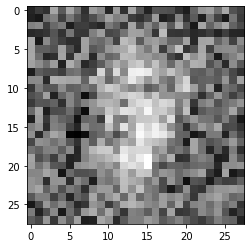

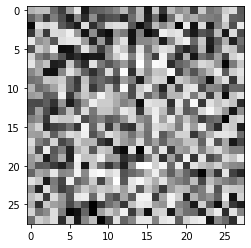

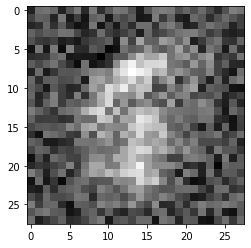

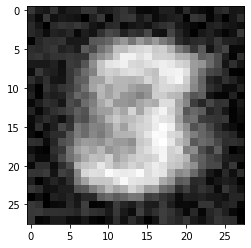

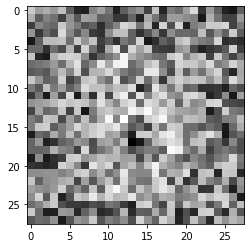

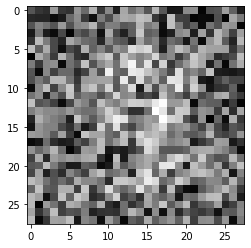

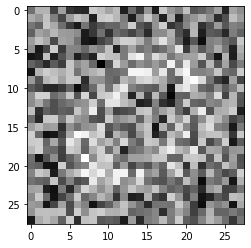

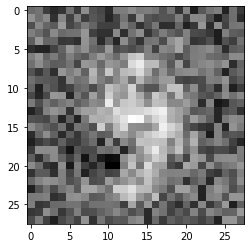

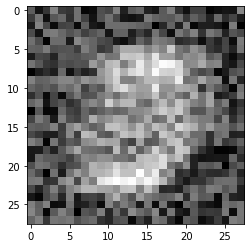

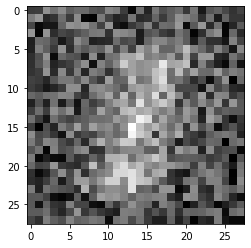

In [17]:
for i in range(10):
    coefs = clf.coefs_[0][:,i]
    coefs = coefs.reshape(28, 28)
    plt.imshow(coefs, cmap='Greys')
    plt.show()

Możemy zauważyć, że dla _większości_ obrazków wagi macierzy aktywacji nie reprezentują konkretnych kształtów.

Wyświetlmy dodatkowo wartości bias dla tych neuronów:

In [11]:
clf.intercepts_[0][:10]

array([ 0.07642884, -0.01604375, -0.06877835, -0.04130371,  0.01280611,
       -0.07110658, -0.03079   , -0.084265  , -0.03832847,  0.0819824 ])

### 1.4) Zadanie

Pokazać jak zmiany parametrów sieci (wielkość sieci dobrać do wielkości danych i możliwości obliczeniowych) tj.
optymalizator, regularyzacja (np., drop-out), funkcja aktywacji i inne wpływa na wynik.
Ważne: __sieć ma być trenowana dla identycznych wag początkowych__ (należy użyć sieci o takim samym rozmiarze i zanicjować sieć z użyciem takiego samego seed'a (parametr `random_state`). 
W sprawozdaniu należy umieścić tabelkę zawierającą rezultaty i wnioski.

| solver | hidden_layers_sizes | activation | alpha | loss | accuracy_score |
|--------|---------------------|------------|-------|------|----------------|
|   sgd  |    (50,)            |  logistic  |  1e-5 |0.296 |    0.9109      |
|   sgd  |    (30,)            |  logistic  |  1e-5 |0.554 |    0.8513      |
|   sgd  |    (70,)            |  logistic  |  1e-5 |0.342 |    0.897       |
|   sgd  |    (50,)            |  tanh      |  1e-5 |0.152 |    0.9489      |
|   sgd  |    (50,)            |  relu      |  1e-5 |0.296 |    0.9109      |
|   adam |    (50,)            |  tanh      |  1e-5 |0.197 |    0.9355      |
|   sgd  |    (50,)            |  tanh      |  1e-4 |0.156 |    0.9477      |
|   sgd  |    (50,)            |  tanh      |  1e-6 |0.162 |    0.9488      |

In [27]:
# rozwiązanie zadania
clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (50,) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\tloss: "+str(accuracy_score(y_test, y_pred)))

sgd (50,) logistic 1e-5
	loss: 0.2962606217461472
	loss: 0.9109


In [28]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(30,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (30,) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\tloss: "+str(accuracy_score(y_test, y_pred)))

sgd (30,) logistic 1e-5
	loss: 0.5543444847477141
	loss: 0.8513


/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [30]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(70,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (70,) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\tloss: "+str(accuracy_score(y_test, y_pred)))

sgd (70,) logistic 1e-5
	loss: 0.34245747500736357
	loss: 0.897


In [31]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100,
    activation="tanh"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (50,) tanh 1e-5")
print("\tloss: "+str(clf.loss_))
print("\tloss: "+str(accuracy_score(y_test, y_pred)))

sgd (50,) tanh 1e-5
	loss: 0.15180182392785657
	loss: 0.9489


/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [32]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100,
    activation="relu"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (50,) relu 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

sgd (50,) relu 1e-5
	loss: 0.2962606217461472
	a_s: 0.9109


/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [33]:

clf = MLPClassifier(
    solver='adam', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=False,
    max_iter=100,
    activation="tanh"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("adam (50,) tanh 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

adam (50,) tanh 1e-5
	loss: 0.19672084708923768
	a_s: 0.9355


In [34]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-4, 
    verbose=False,
    max_iter=100,
    activation="tanh"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (50,) tanh 1e-4")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

sgd (50,) tanh 1e-4
	loss: 0.15645595413432403
	a_s: 0.9477


In [35]:

clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(50,), 
    random_state=SEED, 
    alpha=1e-6, 
    verbose=False,
    max_iter=100,
    activation="tanh"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (50,) tanh 1e-6")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

sgd (50,) tanh 1e-6
	loss: 0.16186296277180026
	a_s: 0.9488


/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# 2) Wpływ długości uczenia sieci na błąd

Zmierzmy dokładność naszej sieci w zależności od długości uczenia. W przypadku stochastycznych solverów (sgd, adam) parametr max_iter oznacza liczbę epok. Jeżeli chcemy użyć innego solvera musimy wyznaczyć odpowiednie batch_size oraz max_iter. Czym jest batch size oraz iteracja w ogólności: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [36]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

In [37]:
from sklearn.utils import resample

X_train, y_train = resample(X_train, y_train, random_state=0, n_samples=200)

In [38]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

start_iter = 10 # startowa ilość iteracji
max_iters = 301  # maksymalna ilość iteracji
step_size = 10   

scores = pd.DataFrame(columns=['n_iters', 'test_score', 'loss'])

for max_iter in range(start_iter, max_iters + 1, step_size):
    clf = MLPClassifier(activation='relu', 
                        hidden_layer_sizes=(512, 256, 128,), # ity element odpowiada wielkości itej warstwy
                        solver='sgd',
                        random_state=0, 
                        max_iter=max_iter, # w przypadku solvera innego niż sgd lub adam trzeba odpowiednio przeliczyć ilość iteracji oraz dodać parametr batch_size
                        learning_rate='adaptive',
                        alpha=1e-4
                       )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)

    row = {
        'n_iters': clf.n_iter_,
        'max_iter': max_iter,
        'train_score': accuracy_score(y_train, y_train_pred),
        'test_score': accuracy_score(y_test, y_pred),
        'loss': clf.loss_
    }
    scores = scores.append(row, ignore_index=True)
                    
scores
                        

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tomasz/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % sel

,n_iters,test_score,loss,max_iter,train_score
0,10.0,0.1045,34.897361,10.0,0.145
1,20.0,0.5005,1.019064,20.0,0.740
2,30.0,0.6191,0.198626,30.0,0.965
3,40.0,0.6494,0.071623,40.0,0.990
4,50.0,0.6608,0.035965,50.0,0.995
5,60.0,0.6677,0.021763,60.0,0.995
6,70.0,0.6695,0.014912,70.0,1.000
7,80.0,0.6701,0.011097,80.0,1.000
8,90.0,0.6707,0.008727,90.0,1.000
9,100.0,0.6728,0.007231,100.0,1.000


Najpierw sprawdźmy jak wygląda ```Accuracy Score``` na zbiorze testowym

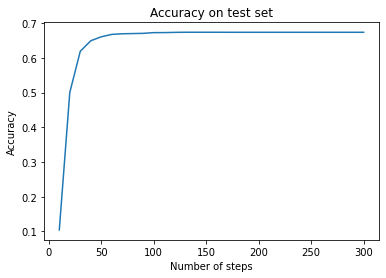

In [39]:
import matplotlib.pyplot as plt

plt.xlabel("Number of steps")
plt.ylabel("Accuracy")
plt.title("Accuracy on test set")
plt.plot(scores['max_iter'], scores['test_score'])
plt.show()

Po ~70 krokach ```Accuracy Score``` przestaje rosnąć. Sprawdźmy zatem jak wygląda ```Accuracy Score``` na zbiorze trzeningowym.

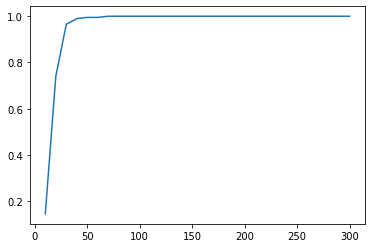

In [40]:
plt.plot(scores['max_iter'], scores['train_score'])

W przypadku zbioru testowego model osiąga prawie 100% skuteczność na samym sobie po ~40 krokach. Po 70 krokach model zna siebie na pamięć przez co nie może się niczego więcej nauczyć. Następuje underfitting- potrzebujemy zwiększyć zbiór treningowy, żeby osiągnął lepsze wyniki.

# 3) Sieci konwolucyjne - Convolutional Neural Network

Sieci konwolucyjne to podklasa sieci neuronowych. Z natury świetnie nadają się do klasyfikacji obrazów oraz wyszukiawania wzroca w obrazie. Ich budowę można podzielić na dwie głównie warstwy:
- warstwa konwolucji
- warstwa sieci neuronowej


Warstwa sieci neuronowej to Fully Connected Network, czyli poznana wcześniej sieć MLP.  
Warstwa konwolucji składa się z 3 etapów:
1. Konwolucji właściwej
2. Operacji ReLU (Rectified Linear Unit)
3. Poolingu


Warstwa konwolucji może być powtórzona wielokrotnie.
Większość frameworków posiada gotowe narzędzia do budowy sieci konwolucyjnych. Poniżej spróbujemy zbudować warstwę konwolucji od zera, aby zobaczyć na czym to polega.

![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-4-59-29-pm.png?w=748)

### 3.1) Konwolucja

Operacja konwolucji jest operacją filtrowania (splotu). Operacja ta przyjmuje na wejściu dwie macierze:

- Macierz $I_{MxN}$ reprezentującą obraz. Dla uproszczenia rozważamy jedynie obrazy w 256 odcieniach szarości. Każdy element macierzy $I$ jest więc liczbą całkowitą z zakresu 0 do 255.
- Macierz $K_{c×c}$, gdzie $c < M$ oraz $c < N$ reprezentującą filtr. Elementami tej macierzy są liczby zmiennoprzecinkowe (często ujemne).

Operacja filtrowania tworzy nowy obraz $J$, którego piksele mają wartość:

$J[x,y]=s_{x, y}$


$s_{x,y}=\sum_{i=1}^{c} \sum_{j=1}^{c}I[x + i - ceil(c/2), y + j - ceil(c/2)]∗k[i,j]$

Powstawły obraz będzie odpowiednio mniejszy, zależnie od wielkości $c$. Indeksowanie w powyższych wzorach zaczyna się od 1.

Konwolucja jest operacją liniową wykonywaną na macierzy, polegającą na aplikacji pewnego filtru, zwanego kernelem. 
![](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196)

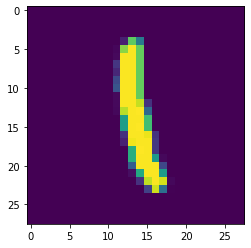

In [41]:
img = X_train[3].reshape(28, 28)
plt.imshow(img)

Zadeklarujmy filtry pierwszej wartswy konwolucyjnej.

In [42]:
l1_filter = np.zeros((2,3,3))
l1_filter[0, :, :] = np.array([[[-1, 0, 1],   
                                   [-1, 0, 1],   
                                   [-1, 0, 1]]])  
l1_filter[1, :, :] = np.array([[[1,   1,  1],   
                                   [0,   0,  0],   
                                   [-1, -1, -1]]])

In [43]:
def conv(img, conv_filter):
    if len(img.shape) != len(conv_filter.shape) - 1: # Check whether number of dimensions is the same
        print("Error: Number of dimensions in conv filter and image do not match.")  
        return 
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            return
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        return
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        return

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

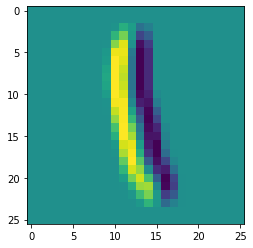

In [44]:
l1_feature_map = conv(img, l1_filter)
plt.imshow(l1_feature_map[:, :, 0])

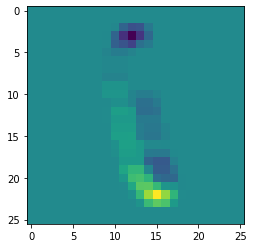

In [45]:
plt.imshow(l1_feature_map[:, :, 1])

### 3.2 ReLU

Operacja konwolucji jest liniowa (mnożenie macierzy oraz sumwanie), co niekonieczenie jest przez nas porządane przy uczeniu sieci neuronowej, gdzie dane wejściowe nie są liniowe. Z pomocą przchodzi prosta funkcja ReLU opisana wzorem $Output = max(0, Input)$, gdzie $Input$ to wartość piksela wynikowej macierzy po zaaplikowaniu filtrów
![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-2-23-48-am.png?w=537&h=168)

In [46]:
def relu(feature_map):  
    relu_out = np.zeros(feature_map.shape)  
    for map_num in range(feature_map.shape[-1]):  
        for r in np.arange(0,feature_map.shape[0]):  
            for c in np.arange(0, feature_map.shape[1]):  
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

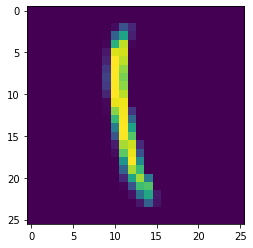

In [47]:
l1_feature_map_relu = relu(l1_feature_map)
plt.imshow(l1_feature_map_relu[:, :, 0])

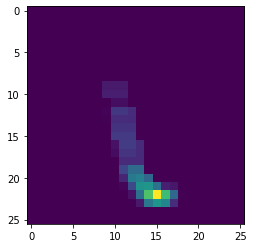

In [48]:
plt.imshow(l1_feature_map_relu[:, :, 1])

Inną funkcją do konwersji danych w nieliniowe, jest poznana wcześniej funkcja sigmoid, jednak ReLU uznawane jest za najlepszą ze względu na wyniki poparte badaniami.

### 3.3 Pooling

Pooling zwany również subsampling lub downsampling jest operacją zmniejszającą ilość rozmiar otrzymanej feature mapy. Rozpatruje się 3 głównie metody pooling:
- Max
- Average
- Sum

Metod tych może być oczywiście więcej.

Operacja jest dosyć intuicyjna. Dzielimy Macierz na podmacierze, na których aplikujemy funkcję poolingu, która zwróci nam w zależności od wybranej metody skalar. W ten sposób uzyskamy mniejszą macież.
![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=494)

In [49]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                            np.uint16((feature_map.shape[1]-size+1)/stride+1),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

(13, 13, 2)

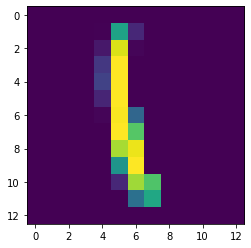

In [50]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)
plt.imshow(l1_feature_map_relu_pool[:, :, 0])
l1_feature_map_relu_pool.shape

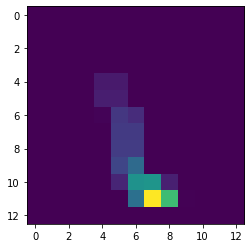

In [51]:
plt.imshow(l1_feature_map_relu_pool[:, :, 1])

Na koniec możemy dodać kolejne warstwy konwolucyjne. Z powodu niwielkich rozmiarów obrazka ograniczymy się do dwóch warstw

In [52]:
l1_feature_map_relu_pool.shape

(13, 13, 2)

In [53]:
l2_filter = np.random.rand(16, 3, 3, l1_feature_map_relu_pool.shape[-1])
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
l2_feature_map_relu = relu(l2_feature_map)
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)

(6, 6, 16)

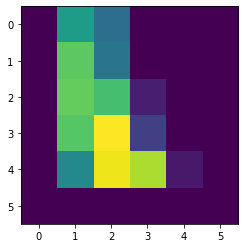

In [54]:
plt.imshow(l2_feature_map_relu_pool[:, :, 0])
l2_feature_map_relu_pool.shape

### 3.4 CNN w Tensorflow

Powyższe kroki wykorzystamy do stworzenia sieci CNN

In [55]:
from tensorflow.keras import models, layers, utils

model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
____

In [56]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 675us/sample - loss: 0.5423 - acc: 0.8446 - val_loss: 0.1416 - val_acc: 0.9582
Epoch 2/10
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.1257 - acc: 0.9617 - val_loss: 0.0832 - val_acc: 0.9741
Epoch 3/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0883 - acc: 0.9727 - val_loss: 0.0630 - val_acc: 0.9786
Epoch 4/10
60000/60000 [==============================] - 32s 529us/sample - loss: 0.0718 - acc: 0.9777 - val_loss: 0.0577 - val_acc: 0.9823
Epoch 5/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.0613 - acc: 0.9814 - val_loss: 0.0450 - val_acc: 0.9860
Epoch 6/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.0544 - acc: 0.9829 - val_loss: 0.0448 - val_acc: 0.9849
Epoch 7/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.0483 - acc: 0.9850 - val_

In [57]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.040032348116021604
Test accuracy: 0.9875


### 3.5 Zadanie dla studentów

Pokazać jak zmiany parametrów sieci (wielkość sieci dobrać do wielkości danych i możliwości obliczeniowych) tj.
ilość wartsw konwolucyjnych, wielkości kerneli, metoda poolingu.
Ważne: __sieć ma być trenowana dla identycznych wag początkowych__ (należy użyć sieci o takim samym rozmiarze i zanicjować sieć z użyciem takiego samego seed'a (parametr `random_state`). 
W sprawozdaniu należy umieścić tabelkę zawierającą rezultaty i wnioski.

| kernel_sizes | layers_no | pooling | loss | accuracy_score |
|--------------|-----------|---------|------|----------------|
|     (3,3)    |     3     |   Max   | 0.040|     0.9875     |
|     (4,4)    |     3     |   Max   | 0.056|     0.9819     |
|     (2,2)    |     3     |   Max   | 0.048|     0.9852     |
|     (3,3)    |     4     |   Max   | 0.034|     0.9888     |
|     (3,3)    |     4     | Average | 0.061|     0.9811     |


In [93]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (4, 4), activation='relu'))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(4,4), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 525us/sample - loss: 0.6274 - acc: 0.8108 - val_loss: 0.1756 - val_acc: 0.9478
Epoch 2/10
60000/60000 [==============================] - 33s 553us/sample - loss: 0.1475 - acc: 0.9549 - val_loss: 0.1113 - val_acc: 0.9648
Epoch 3/10
60000/60000 [==============================] - 44s 731us/sample - loss: 0.1015 - acc: 0.9689 - val_loss: 0.0731 - val_acc: 0.9770
Epoch 4/10
60000/60000 [==============================] - 39s 647us/sample - loss: 0.0828 - acc: 0.9748 - val_loss: 0.0646 - val_acc: 0.9811
Epoch 5/10
60000/60000 [==============================] - 45s 742us/sample - loss: 0.0715 - acc: 0.9776 - val_loss: 0.0562 - val_acc: 0.9812
Epoch 6/10
60000/60000 [==============================] - 34s 570us/sample - loss: 0.0618 - acc: 0.9808 - val_loss: 0.0511 - val_acc: 0.9839
Epoch 7/10
60000/60000 [==============================] - 51s 850us/sample - loss: 0.0552 - acc: 0.9832 

In [94]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(2,2), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 44s 729us/sample - loss: 0.6367 - acc: 0.8084 - val_loss: 0.2355 - val_acc: 0.9265
Epoch 2/10
60000/60000 [==============================] - 30s 500us/sample - loss: 0.1890 - acc: 0.9420 - val_loss: 0.1407 - val_acc: 0.9591
Epoch 3/10
60000/60000 [==============================] - 31s 521us/sample - loss: 0.1215 - acc: 0.9630 - val_loss: 0.0955 - val_acc: 0.9718
Epoch 4/10
60000/60000 [==============================] - 27s 453us/sample - loss: 0.0927 - acc: 0.9710 - val_loss: 0.0752 - val_acc: 0.9763
Epoch 5/10
60000/60000 [==============================] - 28s 465us/sample - loss: 0.0767 - acc: 0.9761 - val_loss: 0.0651 - val_acc: 0.9800
Epoch 6/10
60000/60000 [==============================] - 29s 486us/sample - loss: 0.0669 - acc: 0.9793 - val_loss: 0.0591 - val_acc: 0.9812
Epoch 7/10
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0592 - acc: 0.9818 - 

In [96]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Czwarta warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(3,3), 4 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.7163 - acc: 0.7810 - val_loss: 0.1855 - val_acc: 0.9433
Epoch 2/10
60000/60000 [==============================] - 30s 506us/sample - loss: 0.1425 - acc: 0.9553 - val_loss: 0.0818 - val_acc: 0.9737
Epoch 3/10
60000/60000 [==============================] - 93s 2ms/sample - loss: 0.0930 - acc: 0.9714 - val_loss: 0.0683 - val_acc: 0.9793
Epoch 4/10
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.0741 - acc: 0.9771 - val_loss: 0.0595 - val_acc: 0.9816
Epoch 5/10
60000/60000 [==============================] - 107s 2ms/sample - loss: 0.0615 - acc: 0.9812 - val_loss: 0.0518 - val_acc: 0.9825
Epoch 6/10
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.0532 - acc: 0.9835 - val_loss: 0.0423 - val_acc: 0.9857
Epoch 7/10
60000/60000 [==============================] - 38s 630us/sample - loss: 0.0472 - acc: 0.9856 - val

In [98]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.AveragePooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))

# Trzecia
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Czwarta warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(3,3), 4 layers, AveragePooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 98s 2ms/sample - loss: 1.1560 - acc: 0.6890 - val_loss: 0.3925 - val_acc: 0.8827
Epoch 2/10
60000/60000 [==============================] - 30s 500us/sample - loss: 0.2545 - acc: 0.9230 - val_loss: 0.1690 - val_acc: 0.9518
Epoch 3/10
60000/60000 [==============================] - 107s 2ms/sample - loss: 0.1735 - acc: 0.9473 - val_loss: 0.1352 - val_acc: 0.9567
Epoch 4/10
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1334 - acc: 0.9590 - val_loss: 0.1143 - val_acc: 0.9638
Epoch 5/10
60000/60000 [==============================] - 32s 536us/sample - loss: 0.1101 - acc: 0.9652 - val_loss: 0.0945 - val_acc: 0.9710
Epoch 6/10
60000/60000 [==============================] - 32s 535us/sample - loss: 0.0934 - acc: 0.9710 - val_loss: 0.0805 - val_acc: 0.9741
Epoch 7/10
60000/60000 [==============================] - 33s 548us/sample - loss: 0.0819 - acc: 0.9740 - val

# 4. Zadanie dla studentów

Wnioski z porównania sieci MLP i CNN.
Która otrzymuje lepsze wyniki i dlaczego.

# 5. Zadanie dla studentów

Na zbiorze FMNIST i 20NG (TNG) (można dokonać zmniejszenia ilości wymiarów używając
PCA) porównać performance sieci MLP i CNN w funkcji ilości warstw. Zaczynamy od
jednowarstwowej sieci MLP i minimalnej sieci CNN o porównywalnych ilościach wag.
Następnie zwiększamy liczbę warstw zakładając, że ilość wag jest podobna jak dla
początkowej konfiguracji. WNIOSKI.
Wyniki dokładności porównać do najlepszego modelu klasycznego.

In [3]:
import tensorflow as tf # korzystamy jedynie w celu pobrania zbioru MNIST

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

9


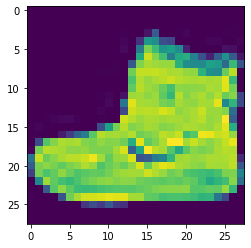

In [10]:
plt.imshow(X_train[0].reshape(28,28))
print(y_train[0])

In [14]:
from sklearn.metrics import accuracy_score

In [28]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(100,), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=True,
    max_iter=100,
    activation="logistic"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (100,) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

Iteration 1, loss = 1.24295023
Iteration 2, loss = 0.78865506
Iteration 3, loss = 0.65981491
Iteration 4, loss = 0.59341695
Iteration 5, loss = 0.56008640
Iteration 6, loss = 0.53251912
Iteration 7, loss = 0.51494502
Iteration 8, loss = 0.49344065
Iteration 9, loss = 0.48717775
Iteration 10, loss = 0.47566114
Iteration 11, loss = 0.47105836
Iteration 12, loss = 0.46454438
Iteration 13, loss = 0.46069707
Iteration 14, loss = 0.45388049
Iteration 15, loss = 0.44886865
Iteration 16, loss = 0.44329009
Iteration 17, loss = 0.43770529
Iteration 18, loss = 0.44049136
Iteration 19, loss = 0.43388215
Iteration 20, loss = 0.43142206
Iteration 21, loss = 0.43233863
Iteration 22, loss = 0.42522189
Iteration 23, loss = 0.42884769
Iteration 24, loss = 0.42634610
Iteration 25, loss = 0.42492141
Iteration 26, loss = 0.42850921
Iteration 27, loss = 0.42041147
Iteration 28, loss = 0.42246674
Iteration 29, loss = 0.42482720
Iteration 30, loss = 0.41914651
Iteration 31, loss = 0.42514215
Iteration 32, los

In [29]:
clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(90,50), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=True,
    max_iter=100,
    activation="logistic"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (90,50) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

Iteration 1, loss = 2.19513952
Iteration 2, loss = 1.99725084
Iteration 3, loss = 1.77642942
Iteration 4, loss = 1.55999070
Iteration 5, loss = 1.37575091
Iteration 6, loss = 1.22866791
Iteration 7, loss = 1.10869376
Iteration 8, loss = 1.01323191
Iteration 9, loss = 0.93652591
Iteration 10, loss = 0.87331277
Iteration 11, loss = 0.82200627
Iteration 12, loss = 0.77911062
Iteration 13, loss = 0.74154015
Iteration 14, loss = 0.70737716
Iteration 15, loss = 0.67728111
Iteration 16, loss = 0.65179751
Iteration 17, loss = 0.62660081
Iteration 18, loss = 0.60183615
Iteration 19, loss = 0.58413917
Iteration 20, loss = 0.56537864
Iteration 21, loss = 0.54899356
Iteration 22, loss = 0.53413871
Iteration 23, loss = 0.52019917
Iteration 24, loss = 0.51029609
Iteration 25, loss = 0.50320437
Iteration 26, loss = 0.49145450
Iteration 27, loss = 0.48652385
Iteration 28, loss = 0.47848546
Iteration 29, loss = 0.46955107
Iteration 30, loss = 0.46544393
Iteration 31, loss = 0.45891770
Iteration 32, los

In [31]:
clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(80,80,70), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=True,
    max_iter=150,
    activation="logistic"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (80,80,70) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

Iteration 1, loss = 2.30197490
Iteration 2, loss = 2.29321102
Iteration 3, loss = 2.28747215
Iteration 4, loss = 2.28048723
Iteration 5, loss = 2.27099564
Iteration 6, loss = 2.25677684
Iteration 7, loss = 2.23533027
Iteration 8, loss = 2.19950629
Iteration 9, loss = 2.13797511
Iteration 10, loss = 2.04150793
Iteration 11, loss = 1.92370303
Iteration 12, loss = 1.82103746
Iteration 13, loss = 1.75023439
Iteration 14, loss = 1.70263647
Iteration 15, loss = 1.66644780
Iteration 16, loss = 1.63546344
Iteration 17, loss = 1.60720156
Iteration 18, loss = 1.57919705
Iteration 19, loss = 1.54945089
Iteration 20, loss = 1.51647797
Iteration 21, loss = 1.47993846
Iteration 22, loss = 1.43960900
Iteration 23, loss = 1.39623183
Iteration 24, loss = 1.35066681
Iteration 25, loss = 1.30848677
Iteration 26, loss = 1.26830884
Iteration 27, loss = 1.23096444
Iteration 28, loss = 1.19938388
Iteration 29, loss = 1.16947851
Iteration 30, loss = 1.14094542
Iteration 31, loss = 1.11197135
Iteration 32, los

In [35]:
clf = MLPClassifier(
    solver='sgd', 
    hidden_layer_sizes=(70,70,60,60), 
    random_state=SEED, 
    alpha=1e-5, 
    verbose=True,
    max_iter=350,
    activation="logistic"
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("sgd (70,70,60,60) logistic 1e-5")
print("\tloss: "+str(clf.loss_))
print("\ta_s: "+str(accuracy_score(y_test, y_pred)))

Iteration 1, loss = 2.31274390
Iteration 2, loss = 2.30249851
Iteration 3, loss = 2.30233891
Iteration 4, loss = 2.30214544
Iteration 5, loss = 2.30200226
Iteration 6, loss = 2.30183945
Iteration 7, loss = 2.30170554
Iteration 8, loss = 2.30153752
Iteration 9, loss = 2.30137168
Iteration 10, loss = 2.30124664
Iteration 11, loss = 2.30112574
Iteration 12, loss = 2.30096608
Iteration 13, loss = 2.30082814
Iteration 14, loss = 2.30064836
Iteration 15, loss = 2.30043248
Iteration 16, loss = 2.30017814
Iteration 17, loss = 2.29997222
Iteration 18, loss = 2.29985774
Iteration 19, loss = 2.29961068
Iteration 20, loss = 2.29933325
Iteration 21, loss = 2.29906448
Iteration 22, loss = 2.29874928
Iteration 23, loss = 2.29850843
Iteration 24, loss = 2.29811803
Iteration 25, loss = 2.29774006
Iteration 26, loss = 2.29733855
Iteration 27, loss = 2.29693547
Iteration 28, loss = 2.29633010
Iteration 29, loss = 2.29578714
Iteration 30, loss = 2.29511452
Iteration 31, loss = 2.29435484
Iteration 32, los

In [39]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [42]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(4,4), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.7051 - acc: 0.7541 - val_loss: 0.5310 - val_acc: 0.8078
Epoch 2/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.4850 - acc: 0.8270 - val_loss: 0.4954 - val_acc: 0.8245
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/sample - loss: 0.4316 - acc: 0.8472 - val_loss: 0.4278 - val_acc: 0.8516
Epoch 4/10
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.3944 - acc: 0.8606 - val_loss: 0.3976 - val_acc: 0.8577
Epoch 5/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.3647 - acc: 0.8702 - val_loss: 0.3927 - val_acc: 0.8590
Epoch 6/10
60000/60000 [==============================] - 137s 2ms/sample - loss: 0.3423 - acc: 0.8794 - val_loss: 0.3640 - val_acc: 0.8690
Epoch 7/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3246 - acc: 0.8843 - val_loss: 0

In [43]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(4,4), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 813us/sample - loss: 0.8999 - acc: 0.6827 - val_loss: 0.6561 - val_acc: 0.7430
Epoch 2/10
60000/60000 [==============================] - 50s 825us/sample - loss: 0.5322 - acc: 0.8034 - val_loss: 0.5008 - val_acc: 0.8133
Epoch 3/10
60000/60000 [==============================] - 53s 883us/sample - loss: 0.4558 - acc: 0.8346 - val_loss: 0.4904 - val_acc: 0.8157
Epoch 4/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.4157 - acc: 0.8494 - val_loss: 0.4391 - val_acc: 0.8386
Epoch 5/10
60000/60000 [==============================] - 55s 924us/sample - loss: 0.3896 - acc: 0.8600 - val_loss: 0.3946 - val_acc: 0.8607
Epoch 6/10
60000/60000 [==============================] - 52s 871us/sample - loss: 0.3695 - acc: 0.8671 - val_loss: 0.4009 - val_acc: 0.8529
Epoch 7/10
60000/60000 [==============================] - 50s 838us/sample - loss: 0.3524 - acc: 0.8727 - 

In [44]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(4,4), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 53s 887us/sample - loss: 0.9640 - acc: 0.6566 - val_loss: 0.6300 - val_acc: 0.7673
Epoch 2/10
60000/60000 [==============================] - 57s 943us/sample - loss: 0.5738 - acc: 0.7828 - val_loss: 0.5403 - val_acc: 0.7979
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.4999 - acc: 0.8127 - val_loss: 0.5040 - val_acc: 0.8132
Epoch 4/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.4548 - acc: 0.8297 - val_loss: 0.4532 - val_acc: 0.8330
Epoch 5/10
60000/60000 [==============================] - 56s 926us/sample - loss: 0.4209 - acc: 0.8454 - val_loss: 0.4330 - val_acc: 0.8422
Epoch 6/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.3980 - acc: 0.8538 - val_loss: 0.4369 - val_acc: 0.8395
Epoch 7/10
60000/60000 [==============================] - 50s 841us/sample - loss: 0.3775 - acc: 0.8610 - val

In [45]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Trzecia warstwa konwolucyjna
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Czwarta warstwa konwolucyjna
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print("(4,4), 3 layers, MaxPooling")
print('\tTest loss:', score[0])
print('\tTest accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 48s 803us/sample - loss: 1.2907 - acc: 0.5390 - val_loss: 0.8184 - val_acc: 0.6999
Epoch 2/10
60000/60000 [==============================] - 44s 740us/sample - loss: 0.7343 - acc: 0.7226 - val_loss: 0.6741 - val_acc: 0.7504
Epoch 3/10
60000/60000 [==============================] - 54s 894us/sample - loss: 0.6149 - acc: 0.7678 - val_loss: 0.5845 - val_acc: 0.7801
Epoch 4/10
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.5433 - acc: 0.7948 - val_loss: 0.5391 - val_acc: 0.7990
Epoch 5/10
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.5017 - acc: 0.8115 - val_loss: 0.5250 - val_acc: 0.7995
Epoch 6/10
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.4707 - acc: 0.8248 - val_loss: 0.4659 - val_acc: 0.8266
Epoch 7/10
60000/60000 [==============================] - 51s 850us/sample - loss: 0.4466 - acc: 0.8333 - val_

|method  |layers |loss  |accuracy_score|
|--------|-------|------|--------------|
|MLP     |1      |0.39  |0.8384        |
|MLP     |2      |0.41  |0.8450        |
|MLP     |3      |0.50  |0.8146        |
|MLP     |4      |0.68  |0.7398        |

|method  |layers |loss  |accuracy_score|
|--------|-------|------|--------------|
|Conv    |1      |0.33  |0.8796        |
|Conv    |2      |0.34  |0.8784        |
|Conv    |3      |0.36  |0.8689        |
|Conv    |4      |0.41  |0.8502        |

Text(0.5, 1.0, 'Layers')

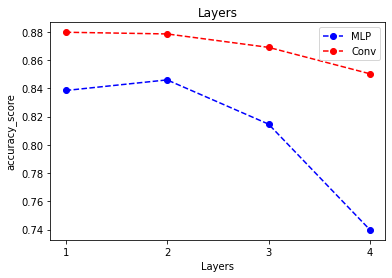

In [75]:
x_mlp = np.array((1,2,3,4))
y_mlp = np.array((0.8384, 0.8459, 0.8146, 0.7398))

x_conv = np.array((1,2,3,4))
y_conv = np.array((0.8796, 0.8784, 0.8689, 0.8502))

plt.plot(x_mlp, y_mlp, 'bo--', label="MLP")
plt.plot(x_conv, y_conv, 'ro--', label="Conv")
plt.xticks([1,2,3,4])
plt.legend()
plt.xlabel("Layers")
plt.ylabel("accuracy_score")
plt.title("Layers")